In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import json
import numpy as np
import math
from nltk import word_tokenize
import torchtext
from transformers import BertTokenizer, BertModel
from transformers import BertConfig, BertForSequenceClassification

batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
train_data = []
train_inp_file = 'processed_data/GCDC/Clinton_train.jsonl'
with open(train_inp_file, 'r') as f:
    for line in f:
        json_obj = json.loads(line)
        # put <EOS> at the end of each sentence and add each sentence to the list
        # for i in range(len(json_obj['sentences'])):
        #     json_obj['sentences'][i].append('<EOS>')
        # merge all sentences into one
        document = " ".join([word for sentence in json_obj['sentences'] for word in sentence])
        document = document.lower()
        label = json_obj['label']
        train_data.append((document, label-1))
   

test_data = []
test_inp_file = 'processed_data/GCDC/Clinton_test.jsonl'
with open(test_inp_file, 'r') as f:
    for line in f:
        json_obj = json.loads(line)
        # put <EOS> at the end of each sentence and add each sentence to the list
        # for i in range(len(json_obj['sentences'])):
        #     json_obj['sentences'][i].append('<EOS>')
        # merge all sentences into one
        document = " ".join([word for sentence in json_obj['sentences'] for word in sentence])
        document = document.lower()
        label = json_obj['label']
        test_data.append((document, label-1))
        
print(len(train_data))
print(train_data[0])
print(train_data[1])
print(train_data[2])
print(len(test_data))
print(test_data[0])

800
('two options the us views the transitional national council as the sole / only legitimate interlocutor of the libyan people during this interim period , as libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all libyans . this is in contrast to the qadhafi regime , which has lost all legitimacy to rule . the us views the transitional national council as the legitimate interlocutor of the libyan people during this interim period , as libyans come together to plan their own future and a permanent , inclusive constitutional system that protects the rights of all libyans . this is in contrast to the qadhafi regime , which has lost all legitimacy to rule . the inc is the institution through which we are engaging the libyan people at this time .', 2)
("ambassador , we just received an email from the adoption service provider about these cases . i am currently reviewing the files to determine if they qualify within 

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_encodings = tokenizer([x[0] for x in train_data], truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer([x[0] for x in test_data], truncation=True, padding=True, return_tensors="pt")

class GCDCDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = GCDCDataset(train_encodings, [x[1] for x in train_data])
test_dataset = GCDCDataset(test_encodings, [x[1] for x in test_data])

In [4]:
print(train_encodings['input_ids'][0])
print(tokenizer.decode(train_encodings['input_ids'][0]))

tensor([  101,  1160,  6665,  1103,  1366,  4696,  1103, 23512,  1569,  3193,
         1112,  1103,  6753,   120,  1178, 11582,  9455, 27089, 21017,  1197,
         1104,  1103,   181, 13292,  6582,  1234,  1219,  1142, 10572,  1669,
          117,  1112,   181, 13292,  6582,  1116,  1435,  1487,  1106,  2197,
         1147,  1319,  2174,  1105,   170,  4088,   117, 21783,  7950,  1449,
         1115, 19819,  1103,  2266,  1104,  1155,   181, 13292,  6582,  1116,
          119,  1142,  1110,  1107,  5014,  1106,  1103,   186,  3556,  2328,
         8702,  6716,   117,  1134,  1144,  1575,  1155, 25844,  1106,  3013,
          119,  1103,  1366,  4696,  1103, 23512,  1569,  3193,  1112,  1103,
        11582,  9455, 27089, 21017,  1197,  1104,  1103,   181, 13292,  6582,
         1234,  1219,  1142, 10572,  1669,   117,  1112,   181, 13292,  6582,
         1116,  1435,  1487,  1106,  2197,  1147,  1319,  2174,  1105,   170,
         4088,   117, 21783,  7950,  1449,  1115, 19819,  1103, 

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# build model
# model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
# load model from file
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3)
model.load_state_dict(torch.load('./bert_clinton.pt'))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [7]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            _, preds = torch.max(logits, dim=1)
            epoch_loss += loss.item()
            epoch_acc += torch.sum(preds == labels).item() / len(labels)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

/tmp/ipykernel_177423/653875629.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

           0       0.56      0.37      0.45        51
           1       0.56      0.13      0.21        38
           2       0.67      0.95      0.78       111

    accuracy                           0.65       200
   macro avg       0.59      0.48      0.48       200
weighted avg       0.62      0.65      0.59       200

	Test Loss: 0.895 | Test Acc: 64.50%


/tmp/ipykernel_177423/653875629.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


[[ 19   4  28]
 [  9   5  24]
 [  6   0 105]]


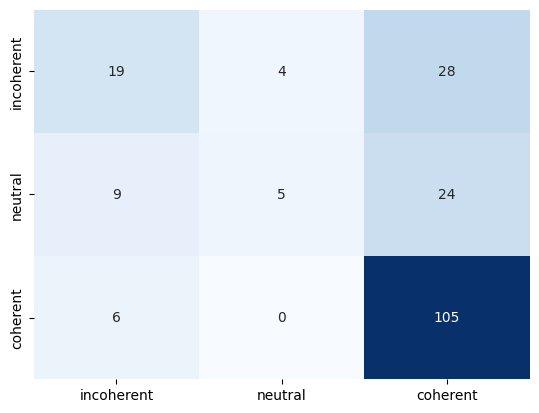

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            _, preds = torch.max(logits, dim=1)
            y_pred.extend(preds.tolist())
            y_true.extend(labels.tolist())
            epoch_loss += loss.item()
            epoch_acc += torch.sum(preds == labels).item() / len(labels)
    print(classification_report(y_true, y_pred))
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        logits = outputs[1]
        _, preds = torch.max(logits, dim=1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())
    
cm = confusion_matrix(y_true, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['incoherent', 'neutral', 'coherent'], yticklabels=['incoherent', 'neutral', 'coherent'])
plt.show()

In [13]:
# predict on a single document
def predict(model, document):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(document, truncation=True, padding=True, return_tensors="pt").to(device)
        outputs = model(**inputs)
        logits = outputs[0]
        _, preds = torch.max(logits, dim=1)
        return preds.item()


In [19]:
print(predict(model, 'Two options\n\nThe US views the Transitional National Council as the sole/only legitimate interlocutor of the Libyan people during this interim period, as Libyans come together to plan their own future and a permanent, inclusive constitutional system that protects the rights of all Libyans. This is in contrast to the Qadhafi regime, which has lost all legitimacy to rule.\n\nThe US views the Transitional National Council as the legitimate interlocutor of the Libyan people during this interim period, as Libyans come together to plan their own future and a permanent, inclusive constitutional system that protects the rights of all Libyans. This is in contrast to the Qadhafi regime, which has lost all legitimacy to rule. The INC is the institution through which we are engaging the Libyan people at this time.'))
print(predict(model, 'My guess is that he is calling about Honduras. He, like many other leaders with an interest in Central America, is worried that Honduras is slipping towards confrontation and violence. He probably does not think Insulza is up to the task. S should be aware that Arias is prepared to offer his services. I spoke with the Costa Rican FonMin, who said the de facto government has reached out to Arias, and that the Costa Ricans will be looking for a way to make the offer to Zelaya. Uribe knows Zelaya and has some influence. Uribe might want to talk with Arias and offer to help move Zelaya in the right direction. (Although Uribe and Zelaya come from different ends of the political spectrum, they are both ranchers and love horses, and this has created some comradeship.'))


2
2


In [21]:
# save each test document and its prediction and true value in a json file
with open('bert_clinton_test.json', 'w') as f:
    json.dump([{'text': x[0], 'prediction': predict(model, x[0]), 'true': x[1]} for x in test_data], f, indent=4)
    


In [26]:
# load the sentences from the X.txt file
with open('./X.txt') as f:
    X = json.load(f)

# predict on each sentence
predictions = [predict(model, x) for x in X]

# save the predictions in a json file along with the sentences
with open('bert_clinton_predictions_for_X.json', 'w') as f:
    json.dump([{'text': x[0], 'prediction': x[1]} for x in zip(X, predictions)], f, indent=4)
    

